In [16]:
#from google.colab import files

In [17]:
#from google.colab import drive
#gdrivepath = '/content/drive'
#drive.mount(gdrivepath)
#BASE_PATH = gdrivepath + "/My Drive/nlp-text-classification/"

In [18]:
import json
import os
import re
import sys
import unicodedata

import numpy as np
import pandas as pd
from tensorflow.keras.layers import (LSTM, Conv1D, Dense, Embedding, Flatten,
                          GlobalMaxPooling1D, Input, MaxPooling1D)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline


class Logger(object):
    def __init__(self, filename="Default.log"):
        self.terminal = sys.stdout
        self.log = open(filename, "w")

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)

    def flush(self):
        self.log.flush()

    def close(self):
        self.log.close()


#sys.stdout = Logger(BASE_PATH + "eval.log")

## Preprocessing
---



In [22]:
GLOVE_FILE = "glove.6B.100d.txt"
DATA_FILE = "twentyng_processed.json"
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 30000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# first, build index mapping words in the embeddings set
# to their embedding vector
print('Loading word vectors...')

embeddings_index = {}
with open(GLOVE_FILE,  encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

# second, prepare text samples and their labels
print("Processing text dataset")

with open(DATA_FILE, "r") as f:
    data = json.load(f)

texts_cleaned = [d["cleaned"] for d in data["data"]]  # list of text samples
texts_cleaned_stemmed = [d["cleaned_stemmed"] for d in data["data"]] # list of text samples

# dictionary mapping label name to numeric id
label_id_to_str = data["label_id_to_str"]
# list of labels for each text in texts as an id
labels_id = [d["label_id"] for d in data["data"]]
# list of labels for each text in texts as an id
labels_str = [d["label_str"] for d in data["data"]]

print("Loaded %s texts." % len(texts_cleaned))

# finally, vectorize the text samples into a 2D integer tensor
"""
Keras provides a Tokenizer class that can be fit on the training data, can convert text to sequences consistently by 
calling the texts_to_sequences() method on the Tokenizer class, and provides access to the dictionary 
mapping of words to integers in a word_index attribute.
"""
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts_cleaned)
sequences = tokenizer.texts_to_sequences(texts_cleaned)
# max sequence length is the maximum number of words in a blog post
texts_cleaned_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
# input are vectors [] length max_sequence_length with [id, id, id, id, pad, pad, pad]
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
type(texts_cleaned_padded)
type(word_index)
# one hot encode the output variable
labels_id = to_categorical(np.asarray(labels_id))
print('Shape of texts tensor:', texts_cleaned_padded.shape)
print('Shape of label tensor:', labels_id.shape)
#print(texts_cleaned_stemmed[:5])
#print(labels_id)
#print("String", labels_str)
#print("label id to str", label_id_to_str)
print('Preparing embedding matrix.')

embeddings_index_reduced = {}
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        embeddings_index_reduced[word] = embedding_vector


# split the data into a training set and a validation set
train_texts_stemmed, test_texts_stemmed, train_texts_cleaned, test_texts_cleaned, train_labels_id, test_labels_id, train_labels_str, test_labels_str = train_test_split(
    texts_cleaned_stemmed, texts_cleaned_padded, labels_id, labels_str, test_size=VALIDATION_SPLIT, random_state=42, stratify=labels_str)

print("Generating embedding matrices")
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer_globve = Embedding(num_words,
                                   EMBEDDING_DIM,
                                   weights=[embedding_matrix],
                                   input_length=MAX_SEQUENCE_LENGTH,
                                   trainable=False)

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True,
                            mask_zero=True)

def get_embedding_layer_globve_trainable():
  em = np.copy(embedding_matrix)
  return Embedding(num_words,EMBEDDING_DIM,weights=[em],input_length=MAX_SEQUENCE_LENGTH,trainable=True)
   

def get_embedding_layer_empty():
  return Embedding(len(word_index) + 1,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH)


Loading word vectors...
Found 400000 word vectors.
Processing text dataset
Loaded 18846 texts.
Found 87701 unique tokens.
Shape of texts tensor: (18846, 100)
Shape of label tensor: (18846, 20)
Preparing embedding matrix.
Generating embedding matrices


## Naive Bayes

---



In [5]:
print('Training baseline model.')

text_clf = Pipeline([('vect', CountVectorizer(analyzer="word",
                                              tokenizer=None,  # irrelevant, we do this manually beforehand
                                              preprocessor=None,  # irrelevant, we do this manually beforehand
                                              lowercase=True,  # irrelevant, we already do this
                                              max_features=MAX_NUM_WORDS,  # limit dictionary
                                              )),
                     # found by grid search
                     ('tfidf', TfidfTransformer(use_idf=True)),
                     # found by grid search
                     ('clf', MultinomialNB(alpha=0.015, fit_prior=False)),
                     ])

print("NB BASE LINE")
text_clf = text_clf.fit(train_texts_stemmed, train_labels_str)
predicted = text_clf.predict(test_texts_stemmed)
print(metrics.classification_report(test_labels_str, predicted))
print(np.mean(predicted == test_labels_str))

Training baseline model.
NB BASE LINE
                          precision    recall  f1-score   support

             alt.atheism       0.39      0.69      0.50       160
           comp.graphics       0.66      0.68      0.67       195
 comp.os.ms-windows.misc       0.72      0.69      0.70       197
comp.sys.ibm.pc.hardware       0.65      0.75      0.70       196
   comp.sys.mac.hardware       0.81      0.76      0.78       193
          comp.windows.x       0.84      0.83      0.84       198
            misc.forsale       0.81      0.76      0.79       195
               rec.autos       0.80      0.73      0.76       198
         rec.motorcycles       0.81      0.72      0.76       199
      rec.sport.baseball       0.91      0.81      0.86       199
        rec.sport.hockey       0.92      0.88      0.90       200
               sci.crypt       0.80      0.74      0.77       198
         sci.electronics       0.76      0.62      0.69       197
                 sci.med       0.90  

## Logistic Regression


---



In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

logreg = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', LogisticRegression(n_jobs=1, C=1e5)),
                  ])

logreg.fit(train_texts_stemmed, train_labels_str)

predicted = logreg.predict(test_texts_stemmed)

print(metrics.classification_report(test_labels_str, predicted))
print('accuracy %s' % accuracy_score(test_labels_str, predicted))
#print(classification_report(test_labels_str, predicted))

C:\Users\subas\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                          precision    recall  f1-score   support

             alt.atheism       0.67      0.62      0.64       160
           comp.graphics       0.69      0.66      0.68       195
 comp.os.ms-windows.misc       0.68      0.70      0.69       197
comp.sys.ibm.pc.hardware       0.65      0.65      0.65       196
   comp.sys.mac.hardware       0.79      0.76      0.77       193
          comp.windows.x       0.80      0.80      0.80       198
            misc.forsale       0.79      0.74      0.76       195
               rec.autos       0.49      0.76      0.60       198
         rec.motorcycles       0.81      0.72      0.76       199
      rec.sport.baseball       0.82      0.81      0.82       199
        rec.sport.hockey       0.89      0.88      0.89       200
               sci.crypt       0.85      0.71      0.77       198
         sci.electronics       0.71      0.63      0.67       197
                 sci.med       0.82      0.86      0.84       198
         

# Decision Tree

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


dtree = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('dt', DecisionTreeClassifier())
                  ])

dtree.fit(train_texts_stemmed, train_labels_str)

predicted = dtree.predict(test_texts_stemmed)

print(metrics.classification_report(test_labels_str, predicted))
print('accuracy %s' % accuracy_score(test_labels_str, predicted))
#print(classification_report(test_labels_str, predicted))

                          precision    recall  f1-score   support

             alt.atheism       0.35      0.34      0.34       160
           comp.graphics       0.37      0.36      0.37       195
 comp.os.ms-windows.misc       0.38      0.39      0.39       197
comp.sys.ibm.pc.hardware       0.36      0.36      0.36       196
   comp.sys.mac.hardware       0.48      0.40      0.44       193
          comp.windows.x       0.48      0.49      0.49       198
            misc.forsale       0.48      0.50      0.49       195
               rec.autos       0.25      0.45      0.32       198
         rec.motorcycles       0.54      0.44      0.49       199
      rec.sport.baseball       0.56      0.49      0.53       199
        rec.sport.hockey       0.67      0.70      0.69       200
               sci.crypt       0.64      0.57      0.60       198
         sci.electronics       0.32      0.30      0.31       197
                 sci.med       0.49      0.50      0.50       198
         

# Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


rforest = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('rf',RandomForestClassifier ())
                  ])

rforest.fit(train_texts_stemmed, train_labels_str)

predicted = rforest.predict(test_texts_stemmed)

print(metrics.classification_report(test_labels_str, predicted))
print('accuracy %s' % accuracy_score(test_labels_str, predicted))
#print(classification_report(test_labels_str, predicted))

                          precision    recall  f1-score   support

             alt.atheism       0.53      0.52      0.53       160
           comp.graphics       0.55      0.52      0.54       195
 comp.os.ms-windows.misc       0.58      0.61      0.60       197
comp.sys.ibm.pc.hardware       0.61      0.59      0.60       196
   comp.sys.mac.hardware       0.71      0.65      0.68       193
          comp.windows.x       0.63      0.73      0.68       198
            misc.forsale       0.64      0.76      0.70       195
               rec.autos       0.39      0.71      0.50       198
         rec.motorcycles       0.67      0.59      0.63       199
      rec.sport.baseball       0.76      0.71      0.74       199
        rec.sport.hockey       0.77      0.84      0.80       200
               sci.crypt       0.82      0.70      0.75       198
         sci.electronics       0.60      0.39      0.47       197
                 sci.med       0.75      0.76      0.75       198
         

## Linear SVM

---
SGD uses only a single sample, i.e., a batch size of one, to perform each iteration. The sample is randomly shuffled and selected for performing the iteration.

In [23]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

sgd.fit(train_texts_stemmed, train_labels_str)
predicted = sgd.predict(test_texts_stemmed)

print('accuracy %s' % accuracy_score(test_labels_str, predicted))

print(metrics.classification_report(test_labels_str, predicted))

accuracy 0.7116710875331564
                          precision    recall  f1-score   support

             alt.atheism       0.72      0.51      0.60       160
           comp.graphics       0.71      0.66      0.68       195
 comp.os.ms-windows.misc       0.66      0.64      0.65       197
comp.sys.ibm.pc.hardware       0.71      0.69      0.70       196
   comp.sys.mac.hardware       0.83      0.75      0.79       193
          comp.windows.x       0.80      0.77      0.78       198
            misc.forsale       0.76      0.77      0.76       195
               rec.autos       0.73      0.75      0.74       198
         rec.motorcycles       0.48      0.72      0.57       199
      rec.sport.baseball       0.78      0.76      0.77       199
        rec.sport.hockey       0.77      0.90      0.83       200
               sci.crypt       0.74      0.76      0.75       198
         sci.electronics       0.70      0.50      0.58       197
                 sci.med       0.75      0.88  

## Doc2Vec

In [10]:
######Doc2Vec######
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
#!pip install gensim
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
import re

def label_sentences(corpus, label_type):
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v, [label]))
    return labeled

x_train = label_sentences(train_texts_stemmed, 'Train')
x_test = label_sentences(test_texts_stemmed, 'Test')

all_data = x_train + x_test

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

C:\Users\subas\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
C:\Users\subas\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
100%|████████████████████████████████████████████████████████████████████████| 18846/18846 [00:00<00:00, 706353.07it/s]


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(x_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(x_test), 300, 'Test')

logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, train_labels_str)
logreg = logreg.fit(train_vectors_dbow, train_labels_str)
y_pred = logreg.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(y_pred, test_labels_str))
print(metrics.classification_report(test_labels_str, y_pred))

<ipython-input-11-60e246afbb9b>:16: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  vectors[i] = model.docvecs[prefix]
C:\Users\subas\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy 0.19575596816976126
                          precision    recall  f1-score   support

             alt.atheism       0.17      0.12      0.14       160
           comp.graphics       0.14      0.16      0.15       195
 comp.os.ms-windows.misc       0.20      0.18      0.19       197
comp.sys.ibm.pc.hardware       0.24      0.26      0.25       196
   comp.sys.mac.hardware       0.19      0.13      0.16       193
          comp.windows.x       0.29      0.49      0.37       198
            misc.forsale       0.20      0.19      0.20       195
               rec.autos       0.11      0.15      0.13       198
         rec.motorcycles       0.20      0.18      0.19       199
      rec.sport.baseball       0.19      0.26      0.22       199
        rec.sport.hockey       0.23      0.27      0.24       200
               sci.crypt       0.21      0.26      0.23       198
         sci.electronics       0.10      0.06      0.07       197
                 sci.med       0.19      0.20 

C:\Users\subas\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history, desc):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy\n' + desc)
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss\n' + desc)
    plt.legend()



In [19]:
from keras.callbacks import CSVLogger

def evaluateModel(model, description, epochs, batch_size, train_texts, train_labels_id, test_texts, test_labels_id):
    try:
        print("\n\n#################### %s ####################" % (description))
        print(model.summary())
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        csv_logger = CSVLogger('/models/' + description + '_run_log.csv')
        history = model.fit(train_texts, train_labels_id, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_texts, test_labels_id), callbacks=[csv_logger])
        #print("\n final results on test set:")
        model.evaluate(test_texts, test_labels_id)
        plot_history(history, description)
    except KeyboardInterrupt:
        print("\ncanceled learning this network!")
    return history


EPOCHS = 30
BATCH_SIZE = 256


## LSTM + GlobVe Embedding Retrained

---





In [20]:

########################
model = Sequential()
model.add(get_embedding_layer_globve_trainable())
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_id_to_str), activation='softmax'))

evaluateModel(model, "LSTM + GlobVe Embedding Retrained", EPOCHS, BATCH_SIZE,
              train_texts_cleaned, train_labels_id, test_texts_cleaned, test_labels_id)




#################### LSTM + GlobVe Embedding Retrained ####################
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          3000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2580      
Total params: 3,119,828
Trainable params: 3,119,828
Non-trainable params: 0
_________________________________________________________________
None


FileNotFoundError: [Errno 2] No such file or directory: '/models/LSTM + GlobVe Embedding Retrained_run_log.csv'

## LSTM + GlobVe Embedding Retrained Batch and Cells

---



In [21]:
########################
for iBATCH_SIZE in [128, 256, 512]:
  for iCells in [64, 128, 256, 512]:
    model = Sequential()
    model.add(get_embedding_layer_globve_trainable())
    model.add(LSTM(iCells, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(len(label_id_to_str), activation='softmax'))

    evaluateModel(model, "LSTM + GlobVe Embedding Retrained Batch %i Cells %i" % (iBATCH_SIZE, iCells), EPOCHS, iBATCH_SIZE, train_texts_cleaned, train_labels_id, test_texts_cleaned, test_labels_id)



#################### LSTM + GlobVe Embedding Retrained Batch 128 Cells 64 ####################
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          3000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1300      
Total params: 3,043,540
Trainable params: 3,043,540
Non-trainable params: 0
_________________________________________________________________
None


FileNotFoundError: [Errno 2] No such file or directory: '/models/LSTM + GlobVe Embedding Retrained Batch 128 Cells 64_run_log.csv'

## simple dense layer neuronal network

---



In [24]:
###############
model = Sequential()
model.add(embedding_layer_globve)
model.add(Dense(256, activation='relu'))
model.add(Flatten())
model.add(Dense(len(label_id_to_str), activation='softmax'))
evaluateModel(model, "simple dense layer neuronal network", EPOCHS, BATCH_SIZE, train_texts_cleaned, train_labels_id, test_texts_cleaned, test_labels_id)




#################### simple dense layer neuronal network ####################
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          3000000   
_________________________________________________________________
dense_4 (Dense)              (None, 100, 256)          25856     
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                512020    
Total params: 3,537,876
Trainable params: 537,876
Non-trainable params: 3,000,000
_________________________________________________________________
None


FileNotFoundError: [Errno 2] No such file or directory: '/models/simple dense layer neuronal network_run_log.csv'

## simple dense layer neuronal network retrainable Dense

---





In [ ]:
###############
for iDense in [128, 256, 512, 1024]:
  model = Sequential()
  model.add(get_embedding_layer_globve_trainable())
  model.add(Dense(iDense, activation='relu'))
  model.add(Flatten())
  model.add(Dense(len(label_id_to_str), activation='softmax'))
  evaluateModel(model, "simple dense layer neuronal network retrainable Dense %i" % iDense, EPOCHS, BATCH_SIZE, train_texts_cleaned, train_labels_id, test_texts_cleaned, test_labels_id)


## Double dense layer neuronal network retrainable Dense

---



In [ ]:
###############
for iDense in [128, 256, 512]:
  model = Sequential()
  model.add(get_embedding_layer_globve_trainable())
  model.add(Dense(iDense, activation='relu'))
  model.add(Dense(iDense, activation='relu'))
  model.add(Flatten())
  model.add(Dense(len(label_id_to_str), activation='softmax'))
  evaluateModel(model, "double dense layer neuronal network retrainable Dense %i" % iDense, EPOCHS, BATCH_SIZE, train_texts_cleaned, train_labels_id, test_texts_cleaned, test_labels_id)


## cnn + lstm + GlobVe Embedding

---



In [ ]:
########################
model = Sequential()
model.add(embedding_layer_globve)
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_id_to_str), activation='softmax'))

evaluateModel(model, "cnn + lstm + GlobVe Embedding", EPOCHS, BATCH_SIZE,
              train_texts_cleaned, train_labels_id, test_texts_cleaned, test_labels_id)


## simple one layer neuronal network retrainable

---



In [ ]:
########################
model = Sequential()
model.add(get_embedding_layer_globve_trainable())
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_id_to_str), activation='softmax'))

evaluateModel(model, "cnn + lstm + GlobVe Embedding Retrainable", EPOCHS, BATCH_SIZE,
              train_texts_cleaned, train_labels_id, test_texts_cleaned, test_labels_id)

## simple one layer neuronal network

---



In [ ]:


###############
model = Sequential()
model.add(embedding_layer_globve)
model.add(Flatten())
model.add(Dense(len(label_id_to_str), activation='softmax'))

evaluateModel(model, "simple one layer neuronal network", EPOCHS, BATCH_SIZE,
              train_texts_cleaned, train_labels_id, test_texts_cleaned, test_labels_id)



## simple one layer neuronal network retrainable

---



In [ ]:
###############
model = Sequential()
model.add(get_embedding_layer_globve_trainable())
model.add(Flatten())
model.add(Dense(len(label_id_to_str), activation='softmax'))

evaluateModel(model, "simple one layer neuronal network retrainable", EPOCHS, BATCH_SIZE,
              train_texts_cleaned, train_labels_id, test_texts_cleaned, test_labels_id)



## LSTM without dropout + custom embedding

---



In [ ]:

########################
model = Sequential()
model.add(get_embedding_layer_empty())
model.add(LSTM(128))
model.add(Dense(len(label_id_to_str), activation='softmax'))

evaluateModel(model, "LSTM without dropout + custom embedding", EPOCHS, BATCH_SIZE,
              train_texts_cleaned, train_labels_id, test_texts_cleaned, test_labels_id)

## LSTM + custom Embedding

---



In [15]:

########################
model = Sequential()
model.add(get_embedding_layer_empty())
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_id_to_str), activation='softmax'))

evaluateModel(model, "LSTM + custom Embedding", EPOCHS, BATCH_SIZE,
              train_texts_cleaned, train_labels_id, test_texts_cleaned, test_labels_id)




#################### LSTM + custom Embedding ####################
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          8770200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2580      
Total params: 8,890,028
Trainable params: 8,890,028
Non-trainable params: 0
_________________________________________________________________
None


NameError: name 'BASE_PATH' is not defined

## LSTM + GlobVe Embedding

---





#################### LSTM + GlobVe Embedding ####################
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 100)          3000000   
_________________________________________________________________
lstm_20 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_41 (Dense)             (None, 20)                2580      
Total params: 3,119,828
Trainable params: 119,828
Non-trainable params: 3,000,000
_________________________________________________________________
None
Train on 15076 samples, validate on 3770 samples
Epoch 1/30
15076/15076 [==============================] - 20s 1ms/step - loss: 2.5643 - acc: 0.1997 - val_loss: 2.0781 - val_acc: 0.3268
Epoch 2/30
15076/15076 [==============================] - 13s 888us/step - loss: 2.0491 - acc: 0.3352 - val_loss: 1.8577 - val_acc:

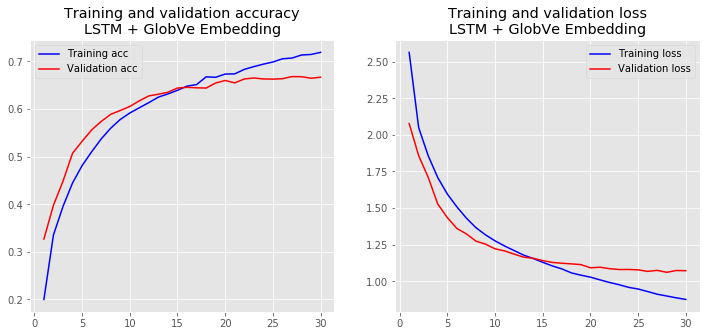

In [ ]:


########################
model = Sequential()
model.add(embedding_layer_globve)
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_id_to_str), activation='softmax'))

evaluateModel(model, "LSTM + GlobVe Embedding", EPOCHS, BATCH_SIZE,
              train_texts_cleaned, train_labels_id, test_texts_cleaned, test_labels_id)


## stacked lstm + GlobVe Embedding

---





#################### stacked lstm + GlobVe Embedding ####################
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 100)          3000000   
_________________________________________________________________
lstm_21 (LSTM)               (None, 128, 128)          117248    
_________________________________________________________________
lstm_22 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_42 (Dense)             (None, 20)                2580      
Total params: 3,251,412
Trainable params: 251,412
Non-trainable params: 3,000,000
_________________________________________________________________
None
Train on 15076 samples, validate on 3770 samples
Epoch 1/30
15076/15076 [==============================] - 36s 2ms/step - loss: 2.4939 - acc: 0.1978 - val_loss: 2.0238 - val_acc

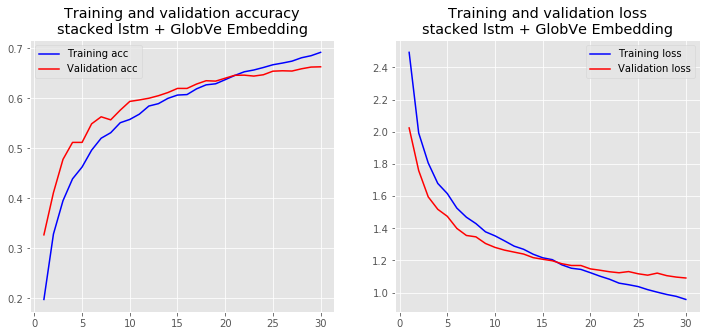

In [ ]:
########################
model = Sequential()
model.add(embedding_layer_globve)
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_id_to_str), activation='softmax'))

evaluateModel(model, "stacked lstm + GlobVe Embedding", EPOCHS, BATCH_SIZE, train_texts_cleaned, train_labels_id, test_texts_cleaned, test_labels_id)


## stacked lstm + GlobVe Embedding Retrainable

---





#################### stacked lstm + GlobVe Embedding Retrainable ####################
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 128, 100)          3000000   
_________________________________________________________________
lstm_23 (LSTM)               (None, 128, 128)          117248    
_________________________________________________________________
lstm_24 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_43 (Dense)             (None, 20)                2580      
Total params: 3,251,412
Trainable params: 3,251,412
Non-trainable params: 0
_________________________________________________________________
None
Train on 15076 samples, validate on 3770 samples
Epoch 1/30
15076/15076 [==============================] - 40s 3ms/step - loss: 2.4510 - acc: 0.2193 - val_loss: 1.8987 - v

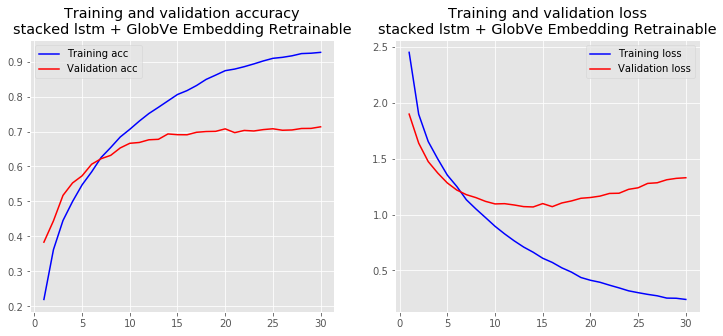

In [ ]:
########################
model = Sequential()
model.add(get_embedding_layer_globve_trainable())
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_id_to_str), activation='softmax'))

evaluateModel(model, "stacked lstm + GlobVe Embedding Retrainable", EPOCHS, BATCH_SIZE, train_texts_cleaned, train_labels_id, test_texts_cleaned, test_labels_id)

## Conv1d with retrained embedding

---





#################### Conv1d with retrained embedding ####################
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 128, 100)          3000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 125, 128)          51328     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 31, 128)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 28, 128)           65664     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 128)            82048     
_________________________________________________________________


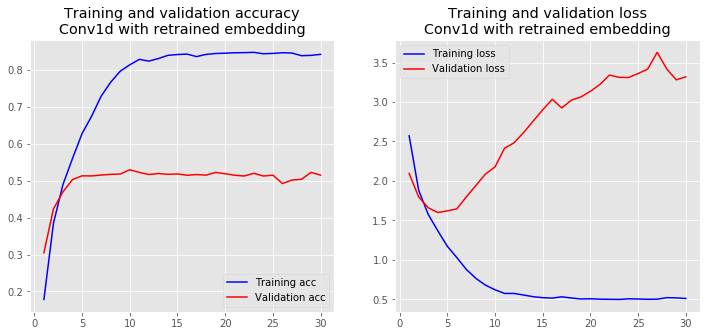

In [ ]:

###############################################
# train a 1D convnet with global maxpooling
model = Sequential()
model.add(get_embedding_layer_globve_trainable())
model.add(Conv1D(128, 4, activation='relu'))
# max pooling ist ein subsampling mit max(), schneller, genauer
model.add(MaxPooling1D(4))
model.add(Conv1D(128, 4, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
# this is the output layer. it has as many neurons as we have labels
model.add(Dense(len(label_id_to_str), activation='softmax'))

evaluateModel(model, "Conv1d with retrained embedding", EPOCHS, BATCH_SIZE, train_texts_cleaned, train_labels_id, test_texts_cleaned, test_labels_id)

## simple dense layer neuronal network

---





#################### simple dense layer neuronal network ####################
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 100)          3000000   
_________________________________________________________________
dense_46 (Dense)             (None, 128, 256)          25856     
_________________________________________________________________
flatten_11 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_47 (Dense)             (None, 20)                655380    
Total params: 3,681,236
Trainable params: 681,236
Non-trainable params: 3,000,000
_________________________________________________________________
None
Train on 15076 samples, validate on 3770 samples
Epoch 1/30
15076/15076 [==============================] - 8s 539us/step - loss: 2.2914 - acc: 0.3102 - val_loss: 1.6987 - va

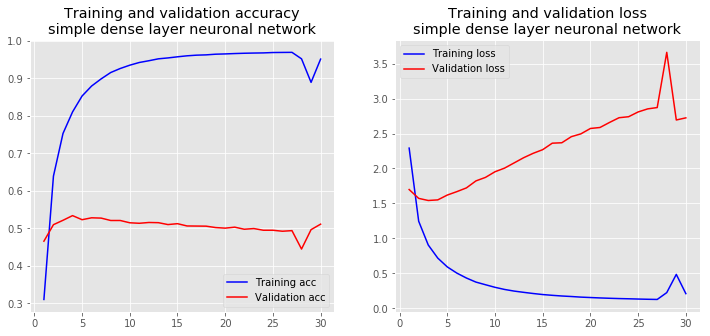

In [ ]:
###############
#####Summation#
model = Sequential()
model.add(embedding_layer_globve)
model.add(Dense(256, activation='relu'))
model.add(Flatten())
model.add(Dense(len(label_id_to_str), activation='softmax'))
evaluateModel(model, "simple dense layer neuronal network", EPOCHS, BATCH_SIZE, train_texts_cleaned, train_labels_id, test_texts_cleaned, test_labels_id)


## BOW with dense 1024

---





#################### bag of words dense 1024 ####################
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 1024)              30721024  
_________________________________________________________________
dense_49 (Dense)             (None, 20)                20500     
Total params: 30,741,524
Trainable params: 30,741,524
Non-trainable params: 0
_________________________________________________________________
None
Train on 15076 samples, validate on 3770 samples
Epoch 1/30
15076/15076 [==============================] - 15s 975us/step - loss: 1.7541 - acc: 0.5956 - val_loss: 1.1648 - val_acc: 0.6942
Epoch 2/30
15076/15076 [==============================] - 6s 397us/step - loss: 0.7531 - acc: 0.8112 - val_loss: 1.0484 - val_acc: 0.7154
Epoch 3/30
15076/15076 [==============================] - 6s 402us/step - loss: 0.4921 - acc: 0.8817 - val_loss: 1.0258 - val_a

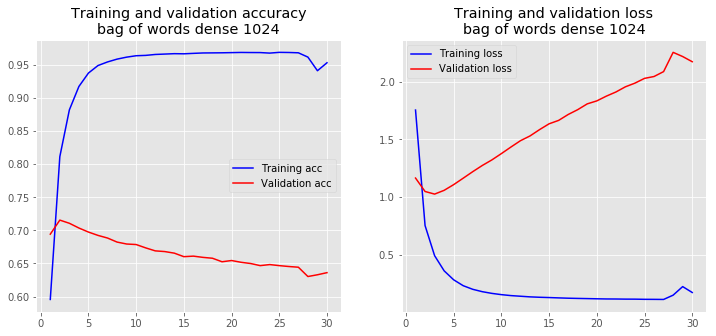

In [ ]:
###############
###############
#BAG OF WORDS##
from keras.layers import Activation, Dense
# from https://cloud.google.com/blog/products/gcp/intro-to-text-classification-with-keras-automatically-tagging-stack-overflow-posts

train_texts_stemmed_bow = tokenizer.texts_to_matrix(train_texts_stemmed)
test_texts_stemmed_bow = tokenizer.texts_to_matrix(test_texts_stemmed)

# labels_id one hot encoded output

model = Sequential()
model.add(Dense(1024, input_shape=(MAX_NUM_WORDS,), activation='relu'))
model.add(Dense(len(label_id_to_str), activation='softmax'))

evaluateModel(model, "bag of words dense 1024", EPOCHS, BATCH_SIZE, train_texts_stemmed_bow, train_labels_id, test_texts_stemmed_bow, test_labels_id)


## HAN

---
 It uses stacked recurrent neural networks on word level followed by attention model to extract such words that are important to the meaning of the sentence and aggregate the representation of those informative words to form a sentence vector. Then the same procedure applied to the derived sentence vectors which then generate a vector who conceives the meaning of the given document and that vector can be passed further for text classification.
 The idea behind the paper is “Words make sentences and sentences make documents”. The intent is to derive sentence meaning from the words and then derive the meaning of the document from those sentences. But not all words are equally important. Some of them characterize a sentence more than others. Therefore we use the attention model so that sentence vector can have more attention on “important” words. Attention model consists of two parts: Bidirectional RNN and Attention networks. 

![alt text](https://cdn-images-1.medium.com/max/1600/1*28XVtq2lOjOmZhcSgu1NmQ.png)

In [ ]:
import keras
keras.__version__

'2.2.4'

In [ ]:
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras import layers
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

MAX_SEQ = 15

class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim, )))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)

        ait = K.exp(ait)

        if mask is not None:
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

sentence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
l_att = AttentionLayer(100)(l_lstm)
sentEncoder = Model(sentence_input, l_att)

review_input = Input(shape=(MAX_SEQ, MAX_SEQUENCE_LENGTH), dtype='int32')
review_encoder = TimeDistributed(sentEncoder)(review_input)
l_lstm_sent = Bidirectional(GRU(100, return_sequences=True))(review_encoder)
l_att_sent = AttentionLayer(100)(l_lstm_sent)
preds = Dense(2, activation='softmax')(l_att_sent)
model = Model(review_input, preds)

evaluateModel(model, "Hierarchical Attention Networt", EPOCHS, BATCH_SIZE, train_texts_stemmed_bow, train_labels_id, test_texts_stemmed_bow, test_labels_id)




## GridSearchCV

---



In [ ]:

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(optimizer='rmsprop', init='glorot_uniform'):
    model = Sequential()
    model.add(Dense(12, input_shape=(MAX_NUM_WORDS,), kernel_initializer=init, activation='relu'))
    model.add(Dense(8, kernel_initializer=init, activation='relu'))
    model.add(Dense(num_classes, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

np.random.seed(47)
model = KerasClassifier(build_fn = create_model, verbose = 0)

optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [50, 100, 150]
batches = [5, 10, 20]

param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(x_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
